<a href="https://colab.research.google.com/github/AilingLiu/TMDB_Box_Office_Prediction/blob/master/tmdb_box_office_revenue_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Competition details

`https://www.kaggle.com/c/tmdb-box-office-prediction/data`


# Overview



---


In this competition, you're presented with metadata on over 7,000 past films 
from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

# Set up

In [0]:
import sys
sys.version_info >= (3, 5) # evaluate python version is 3.5 and later

import sklearn
sklearn.__version__ >= '0.20' # evaluate sklearn version is 0.2 and later

# common imports
import os
import numpy as np

# setting figure
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# figure saving location
PROJECT_ROOT_DIR = '.'
PROJECT_ID = 'tmdb_movie_revenue'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', PROJECT_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(image_name, save_in=IMAGE_PATH, tight_layout=True, dpi=300, image_extension='png'):
  path=os.path.join(IMAGE_PATH, image_name + '.' + image_extension)
  print('Saving Picture: ', image_name)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=image_extension, dpi=dpi)

# Get Data

In [0]:
URL_PATH = 'https://github.com/AilingLiu/TMDB_Box_Office_Prediction/raw/master/tmdb-box-office-prediction.zip'
DATA_PATH = os.path.join('datasets', PROJECT_ID)

from zipfile import ZipFile
import urllib

def fetch_data(url=URL_PATH, to_local=DATA_PATH):
  zip_path = os.path.join(DATA_PATH, 'tmdb_movie_revenue.zip')
  if not os.path.isdir(to_local):
    os.makedirs(to_local)
  urllib.request.urlretrieve(URL_PATH, zip_path)
  zip_=ZipFile(zip_path, 'r')
  zip_.extractall(DATA_PATH)
  zip_.close()

In [0]:
fetch_data()

In [39]:
# quick look of csv data in shell command
!head -n 4 datasets/tmdb_movie_revenue/train.csv

﻿id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]",14000000,"[{'id': 35, 'name': 'Comedy'}]",,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be V

In [0]:
import pandas as pd

def load_data(train_set=True, data_path=DATA_PATH):
  if train_set:
    path=os.path.join(data_path, 'train.csv')
  else:
    path=os.path.join(data_path, 'test.csv')
  return pd.read_csv(path, index_col='id')

In [7]:
movies=load_data()
movies.head(2)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [54]:
!head -n 4 'datasets/tmdb_movie_revenue/train.csv'

﻿id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]",14000000,"[{'id': 35, 'name': 'Comedy'}]",,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be V

In [0]:
# Some columns contain sort of json format in string format. We can use the pandas `converter` trick to cast string to whatever format we want

def string_to_list(x):
  return eval(x) if x and x != '#N/A' else []

io_columns = [
              'belongs_to_collection',
              'genres',
              'production_companies',
              'production_countries',
              'spoken_languages',
              'Keywords',
              'cast',
              'crew'
]


io_params = {
    'index_col': 'id',
    'converters': {col: string_to_list for col in io_columns}
    
}

def load_data(train_set=True, data_path=DATA_PATH, params=io_params):
  if train_set:
    path=os.path.join(data_path, 'train.csv')
  else:
    path=os.path.join(data_path, 'test.csv')
  return pd.read_csv(path, **io_params)

In [48]:
movies = load_data()
movies.head(3)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,[],3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [50]:
movies.iloc[:3, 0] # Now we can see the `blongs_to_collection` format become list of dictionaries, instead of string, and nan is empty list.

id
1    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
2    [{'id': 107674, 'name': 'The Princess Diaries ...
3                                                   []
Name: belongs_to_collection, dtype: object

In [52]:
movies.iloc[0, 0]

[{'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg',
  'id': 313576,
  'name': 'Hot Tub Time Machine Collection',
  'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg'}]

# Quick view of data structure

In [53]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords                 3000 non-null object
cast               

this data has only 3000 entries, quite a small dataset. There are 22 columns, including the target column `revenue`. It has four numerical attributes, and the remaining attributes are object type. 

In [55]:
movies.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


Saving Picture:  scatter_matrix_of_movies


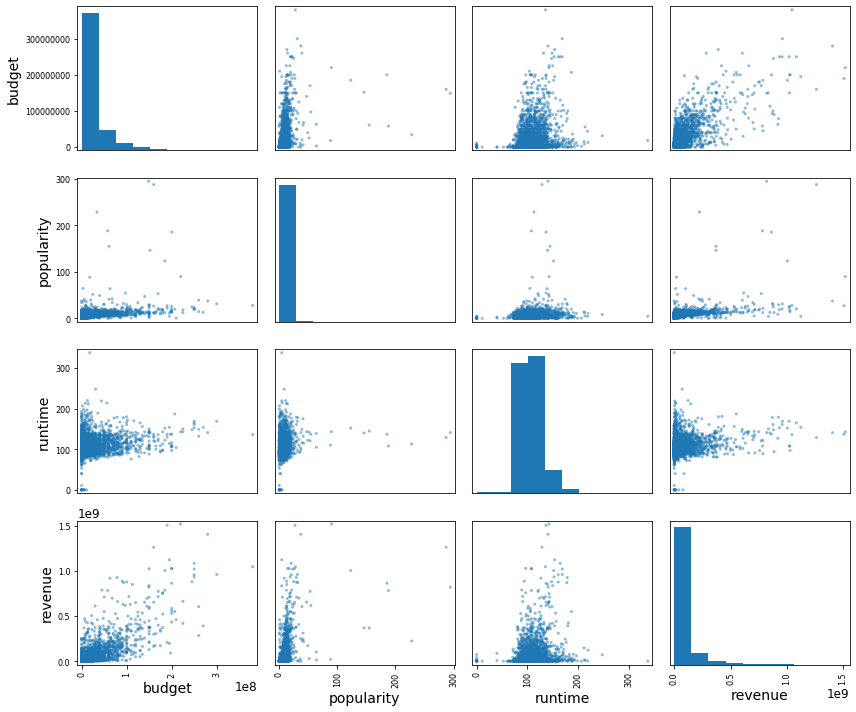

In [60]:
from pandas.plotting import scatter_matrix

scatter_matrix(movies, figsize=(12, 10));
save_fig('scatter_matrix_of_movies')

**`budget`** and **`revenue`** appear to have pretty positive linear relation. the more budget that the movie spent, the more revenue it gaine. Most of times are true especially for commercial movies. But there are exceptions nowadays. There are data scattered far from the main area.

Popularity is stable regardless of revenue and popularity increases. However, we can also see that the images has been reduced/squeezed by the outliers from 30 and beyond. We need to clean the outliers to have a closer look on this attributes. **`runtime`** is normally distributed. We can find out the average runtime for most of the movies from this dataset. 

Lastly, notice that the unit of popularity and runtime (from 0 to 300) is much less than budget and revenue (million). We can change that as well for buiding the regression model.

# Test set

Let's set aside test set so we will not have visibility on the patterns that might seem interesting in test set and get overfitting in our models. 

In [0]:
from sklearn.model_selection import train_test_split

dev_set, val_set = train_test_split(movies, test_size=0.3, random_state=42)

# Analysis of data with visualisation

In [68]:
# We can take a quick look at the simple dataset for a quick start (the ones not in io_params, not in list of dictionaries.)

potential_col = dev_set.columns.difference(io_columns)
potential_col

Index(['budget', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'release_date', 'revenue',
       'runtime', 'status', 'tagline', 'title'],
      dtype='object')

In [70]:
# Original_language should be low cardinality. Good start to look at
print('Total different languages: {}'.format(dev_set.original_language.nunique()))
dev_set['original_language'].value_counts()

Total different languages: 33


en    1797
fr      53
ru      38
hi      29
ja      28
es      25
ko      17
it      16
de      15
zh      15
ta      13
cn      10
sv       6
pt       5
da       4
ro       4
nl       4
fa       2
ml       2
pl       2
te       2
fi       2
ar       1
sr       1
el       1
bn       1
he       1
nb       1
ur       1
hu       1
no       1
mr       1
vi       1
Name: original_language, dtype: int64

Saving Picture:  revenue_budget_by_languages


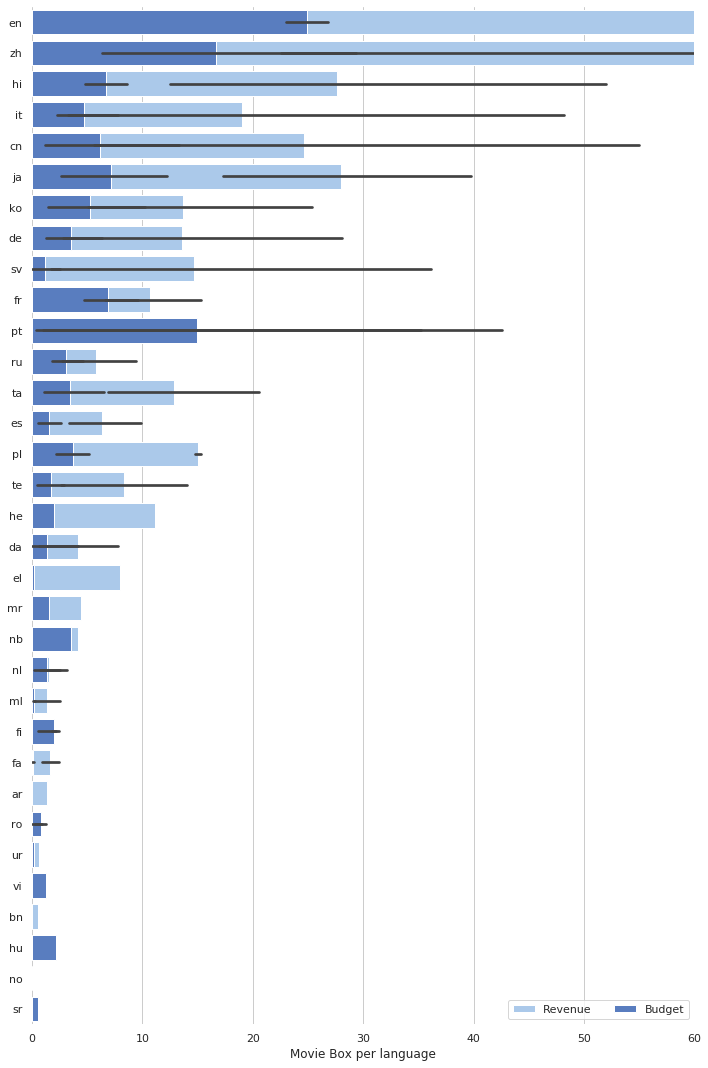

In [84]:
import seaborn as sns

sns.set(style="whitegrid")
dev_=dev_set.sort_values(by='revenue', ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

#Plot the total revenue
sns.set_color_codes("pastel")
sns.barplot(y=dev_['original_language'], x=dev_["revenue"]/1000000,
            label="Revenue", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y=dev_["original_language"], x=dev_["budget"]/1000000,
            label="Budget", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 60), ylabel="",
       xlabel="Movie Box per language")
sns.despine(left=True, bottom=True)

save_fig('revenue_budget_by_languages')

More than half of those languages do not have enough data to be represensitive. We can consider to group the minority as an independent group.

Saving Picture:  Barplot of Revenue by Country


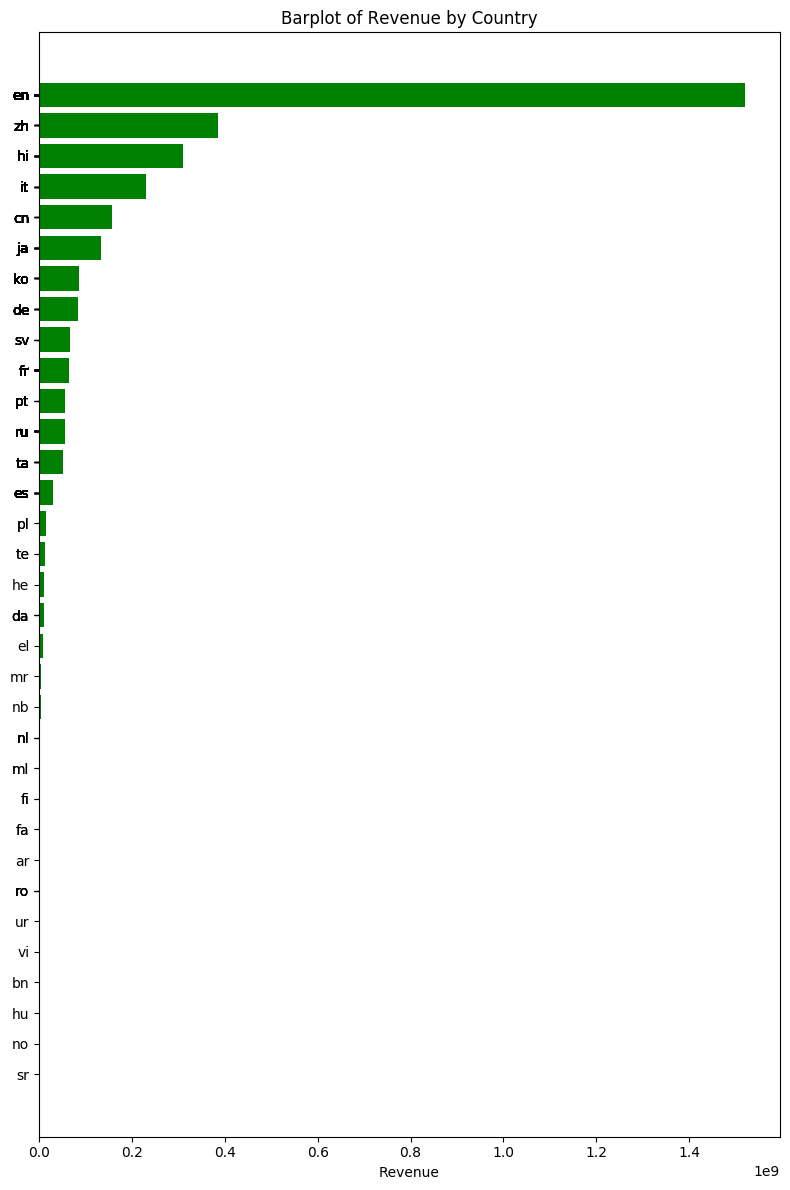

In [89]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

# Example data
y_pos = dev_.original_language
x_pos = dev_.revenue

ax.barh(y_pos, x_pos, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
#ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Revenue')
ax.set_title('Barplot of Revenue by Country')
save_fig('Barplot of Revenue by Country')
plt.show()

In [79]:
dev_.revenue[:10]

id
1755    1
1875    1
1918    1
1542    3
335     3
2118    4
1347    5
2491    6
640     8
2252    8
Name: revenue, dtype: int64

In [71]:
# Next take a look at status
dev_set['status'].value_counts()

Released    2098
Rumored        2
Name: status, dtype: int64